In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as Fn

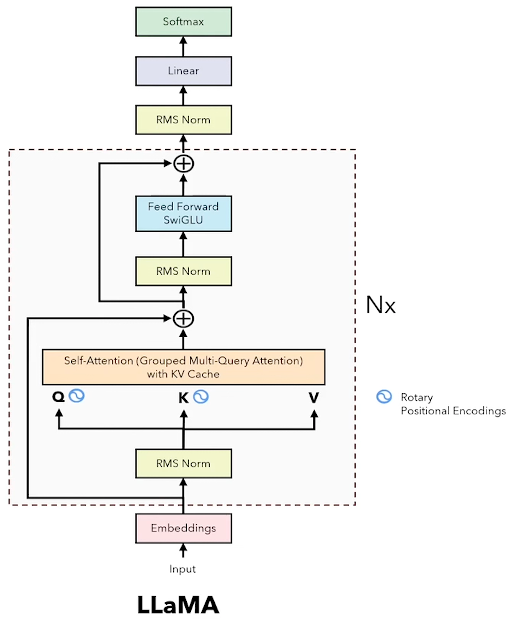

See Notes as well for Diagram and Key Concepts are
- Grouped Query Attention
- KV Cache
- SwigLU Activation
- RMS Norm
- Rotatory Position Encoding in Q and K


https://www.youtube.com/watch?v=oM4VmoabDAI

In [7]:
def thetaFrequencies(dimension, seqLen, theta = 10000.0):
    '''
    m = [1, 2, 3, .... seqLen]
    theta = [theta1, theta2, theta3, .... theta{dim/2}]
    freq = 
    [
        [m1theta1, m1theta2, ..... m1theta{dim/2}],
        [m2theta1, m2theta2, ..... m2theta{dim/2}],
        [m3theta1, m3theta2, ..... m3theta{dim/2}],
        .....
        [m1theta1, m1theta2, ..... m1theta{dim/2}],

    ]
    complexForm of freq matrix
    '''
    thetaNum = torch.arange(0, dimension, 2).float()
    value =  1.0 / (theta ** (thetaNum/dimension))
    m = torch.arange(seqLen)
    freq = torch.outer(m, value).float()

    complexFreq = torch.polar(torch.ones_like(freq), freq)

    return complexFreq

dimension = 4096
seqLen = 512
y = thetaFrequencies(dimension, seqLen)
y, y.shape

(tensor([[ 1.0000+0.0000e+00j,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
           ...,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
           1.0000+0.0000e+00j],
         [ 0.5403+8.4147e-01j,  0.5441+8.3904e-01j,  0.5478+8.3660e-01j,
           ...,  1.0000+1.0136e-04j,  1.0000+1.0090e-04j,
           1.0000+1.0045e-04j],
         [-0.4161+9.0930e-01j, -0.4080+9.1300e-01j, -0.3998+9.1660e-01j,
           ...,  1.0000+2.0272e-04j,  1.0000+2.0181e-04j,
           1.0000+2.0090e-04j],
         ...,
         [ 0.9981+6.1950e-02j, -0.6061-7.9535e-01j, -0.2150+9.7661e-01j,
           ...,  0.9987+5.1568e-02j,  0.9987+5.1337e-02j,
           0.9987+5.1107e-02j],
         [ 0.4871+8.7333e-01j,  0.3375-9.4131e-01j, -0.9348+3.5509e-01j,
           ...,  0.9987+5.1670e-02j,  0.9987+5.1438e-02j,
           0.9987+5.1207e-02j],
         [-0.4717+8.8177e-01j,  0.9734-2.2893e-01j, -0.8092-5.8754e-01j,
           ...,  0.9987+5.1771e-02j,  0.9987+5.1539e-02j,
           0.9987+5.1308e-02j]]),
 torch

In [ ]:
def applyRotatoryEmbeddings(x, complexFreq):
    '''    
    :param x: Embedding Vectors (Query and Key) 
    (batch, SeqLen, Head, HeadDim) -> (batch, SeqLen, Head, HeadDim/2) -> (1, seqLen, 1, headDim/2)
    :param complexFreq: from above
    '''
    xComplex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    complexFreq = complexFreq.unsqueeze(0).unsqueeze(2)

    xRotated = xComplex * complexFreq
    out = torch.view_as_real(xRotated).reshape(*x.shape)

    return out.type_as(x)

dimension = 4096
seqLen = 512
y = thetaFrequencies(dimension, seqLen)
query = torch.randn(2, seqLen, 8, dimension)
rotated = applyRotatoryEmbeddings(query, y)
rotated, rotated.shape

(tensor([[[[ 1.6232e+00, -6.3834e-01, -5.5329e-01,  ...,  3.9697e-01,
            -4.8623e-01, -1.3827e-01],
           [-7.0547e-01, -7.5838e-01,  3.5206e-01,  ..., -4.0481e-02,
             2.0534e+00,  9.7054e-01],
           [-3.3872e-01,  8.4304e-01,  1.1615e+00,  ..., -1.4151e-01,
             5.8839e-01, -1.4251e+00],
           ...,
           [-4.2783e-01, -2.1044e+00, -1.4492e+00,  ..., -6.6720e-01,
            -1.3522e+00, -1.1352e+00],
           [ 1.2521e+00, -8.3642e-01, -9.6892e-01,  ..., -1.3163e-01,
             1.0025e-01, -2.6807e-01],
           [ 7.7009e-02, -1.5099e+00,  1.0940e+00,  ..., -7.7568e-01,
            -2.7939e-01, -7.8800e-02]],
 
          [[-1.6211e+00,  7.0844e-01, -1.6802e+00,  ..., -1.4719e+00,
            -1.0994e-01, -1.3013e+00],
           [ 1.9498e+00, -2.8117e-03,  1.0569e+00,  ..., -1.1753e+00,
            -1.6243e+00,  9.8544e-01],
           [-5.1784e-02, -2.1552e+00,  3.7457e-01,  ..., -6.1813e-01,
            -5.9654e-01,  8.6611e-01],


In [9]:
class RMSNorm(nn.Module):

    def __init__(self, dimension):
        super().__init__()
        self.eps = 1e-6
        self.weight = nn.Parameter(torch.ones(dimension))

    def forward(self, x):
        xNorm = x * torch.rsqrt(x.pow(2).mean(-1, keepdim = True) + self.eps)
        normalized = self.weight * xNorm 
        return normalized.type_as(x)
    
rmsN = RMSNorm(dimension)
embeddings = torch.randn(2, seqLen, dimension)
norm = rmsN(embeddings)
norm, norm.shape

(tensor([[[ 1.0486, -0.3691,  0.1902,  ...,  0.5378,  0.1910,  0.3915],
          [-0.6269, -1.9916,  0.5740,  ...,  0.3270, -0.8467,  0.2340],
          [-0.4554,  1.2930, -1.8947,  ...,  1.9123,  0.0451, -1.4840],
          ...,
          [ 0.0846,  0.6446, -0.8914,  ..., -0.0183,  0.7262, -0.2353],
          [ 0.8903, -1.4934,  0.3616,  ...,  1.3218, -1.6248,  1.4300],
          [ 0.6225, -0.9741, -0.2730,  ...,  0.4764, -0.9196, -0.3973]],
 
         [[ 0.0489,  1.8594,  0.1830,  ...,  0.8234,  1.0641,  0.9521],
          [ 0.4064, -1.2811, -1.4832,  ...,  0.8931, -0.5053, -0.0648],
          [-1.0896, -0.5445,  0.1572,  ..., -0.0048, -0.0637,  0.0316],
          ...,
          [-0.9961, -0.2002, -0.5123,  ..., -1.4770,  0.0436,  0.0965],
          [ 1.0904,  0.2579, -0.8257,  ...,  0.8288, -0.6695, -0.1126],
          [-0.0343,  0.0953, -0.0426,  ...,  0.3244, -0.2163,  0.4053]]],
        grad_fn=<MulBackward0>),
 torch.Size([2, 512, 4096]))

In [11]:
'''
KV-Cache

Now, think seq-to-seq how does it work
I am Ishan, and I am developing new Architecture for T2I
I -> am
I am -> Ishan
I am Ishan -> ,
I am Ishan , -> and
I am Ishan, and -> I .....
I am Ishan, and I am developing new Architecture for -> T2I

so we have to input the tokens repetedily again and again, 
instead of this, it can be take care of by KV-Cache

It will cache the input tokens, and we don't need to put the input
embeddings again and again


I don't think this can help anyway in Text to Image Generation, as we are generating Image one by one, 
but this can be helpful when doing it with Video Generation.. keep this in Mind
'''


"\nKV-Cache\n\nNow, think seq-to-seq how does it work\nI am Ishan, and I am developing new Architecture for T2I\nI -> am\nI am -> Ishan\nI am Ishan -> ,\nI am Ishan , -> and\nI am Ishan, and -> I .....\nI am Ishan, and I am developing new Architecture for -> T2I\n\nso we have to input the tokens repetedily again and again, \ninstead of this, it can be take care of by KV-Cache\n\nIt will cache the input tokens, and we don't need to put the input\nembeddings again and again\n\n\nI don't think this can help anyway in Text to Image Generation, as we are generating Image one by one, \nbut this can be helpful when doing it with Video Generation.. keep this in Mind\n"

## Attention without KV Cache
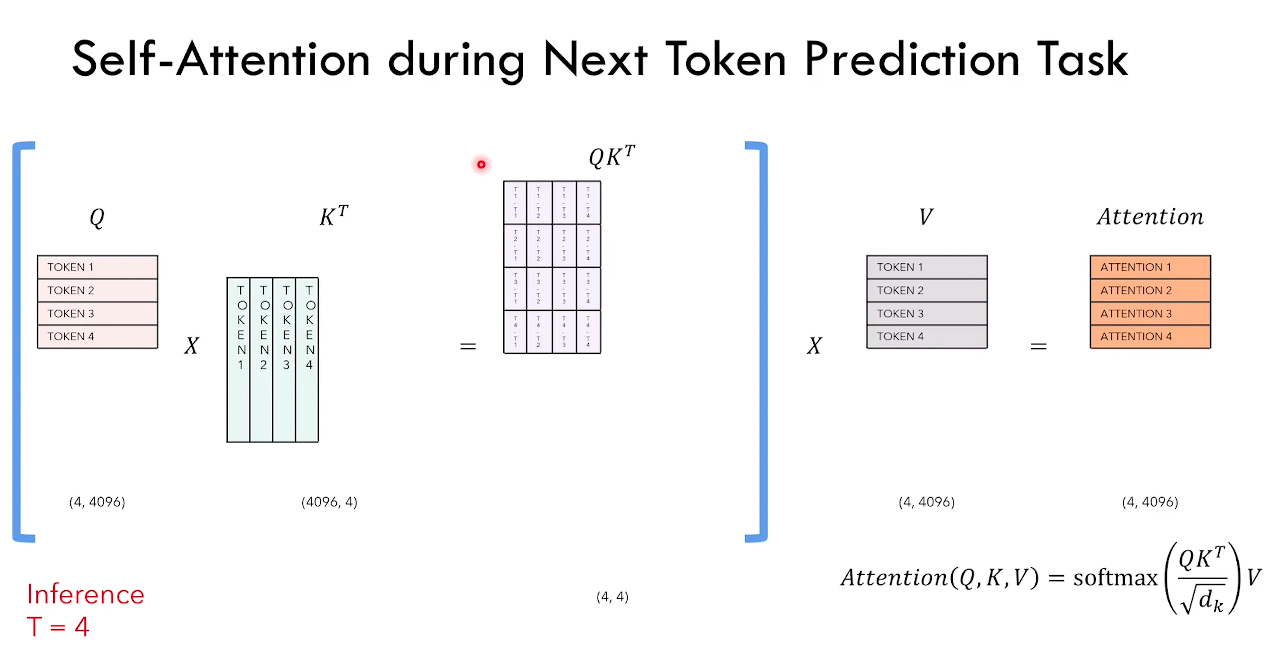

## Attention with KV Cache
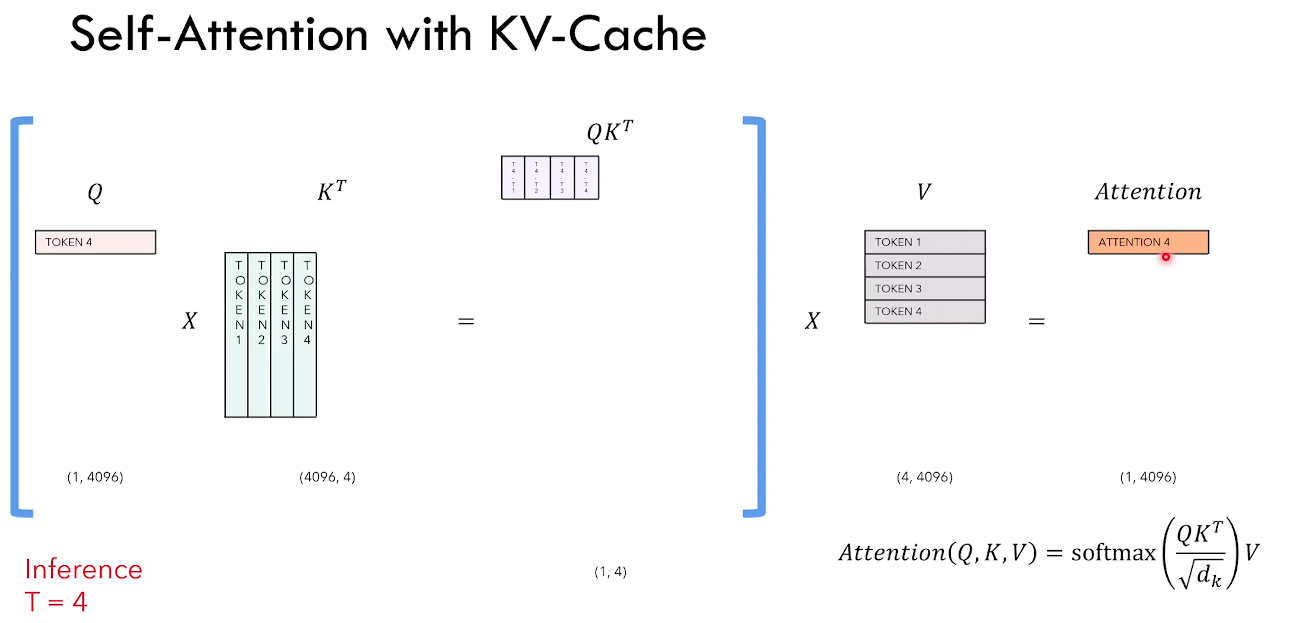

In [12]:
'''
SWIGLU Works better, but there is no Reason Given
'''


'\nSWIGLU Works better, but there is no Reason Given\n'

In [ ]:
class FeedForwardLayer(nn.Module):
    def __init__(self, dimension=2048, hidden_dim=None):
        super().__init__()
        
        if hidden_dim is None:
            hidden_dim = 4 * dimension
        
        self.w1 = nn.Linear(dimension, hidden_dim)  
        self.w2 = nn.Linear(hidden_dim, dimension)  
        self.w3 = nn.Linear(dimension, hidden_dim)  

    def forward(self, x):
        swish = Fn.silu(self.w1(x))  
        xV = self.w3(x)
        x = swish * xV
        
        x = self.w2(x)
        
        return x

ffn = FeedForwardLayer(dimension=2048)
x = torch.randn(2, 1024, 2048)
out = ffn(x)
out.shape

torch.Size([2, 1024, 2048])

In [25]:
'''
Beam Search with Beam Size K,
Temprature : 
    A Low Temprature makes the model more condifent (the gap between low and high probabilites increases)
    A high Temprature makes the model less confident (the gap between low and high probabilities reduces)

output <- softmax(final layer) version 1
output <- softmax(final layer/ temprature) version 2 we can tweak the temprature high or low {... 0.1, 0.4 ... 5, 10..}

'''


'\nBeam Search with Beam Size K,\nTemprature : \n    A Low Temprature makes the model more condifent (the gap between low and high probabilites increases)\n    A high Temprature makes the model less confident (the gap between low and high probabilities reduces)\n\noutput <- softmax(final layer) version 1\noutput <- softmax(final layer/ temprature) version 2 we can tweak the temprature high or low {... 0.1, 0.4 ... 5, 10..}\n\n'

In [26]:
finalyLayer = torch.Tensor([-2.5, -3, -0.6])

In [27]:
torch.softmax(finalyLayer, dim=0) 
# No Temprature

tensor([0.1206, 0.0731, 0.8063])

In [28]:
torch.softmax(finalyLayer/0.4, dim=0) 
# Low Temprature

tensor([0.0086, 0.0025, 0.9890])

In [29]:
torch.softmax(finalyLayer / 5, dim=0) 
# High Temprature

tensor([0.2970, 0.2687, 0.4343])

Input Tokens (x)
     │
     ▼
┌───────────────────────────────────────────┐
│        Multi-Frequency Attention          │
│                                           │
│  ┌──────────┐  ┌──────────┐  ┌──────────┐ │
│  │ Low Freq │  │ Mid Freq │  │ High Freq│ │
│  │ (Delta/  │  │ (Alpha/  │  │ (Gamma)  │ │
│  │  Theta)  │  │  Beta)   │  │          │ │
│  └──────────┘  └──────────┘  └──────────┘ │
│        │             │             │      │
│        └──────┬──────┴──────┬──────┘      │
│               ▼             ▼             │
│        Frequency Gating / Fusion          │
└───────────────────────────────────────────┘
     │
     ▼
   Add & Norm
     │
     ▼
┌───────────────────────────────────────────┐
│ Frequency-Aware Feed Forward (optional)   │
│  ┌────────┐ ┌────────┐ ┌────────┐        │
│  │ Low FFN│ │ Mid FFN│ │ HighFFN│        │
│  └────────┘ └────────┘ └────────┘        │
└───────────────────────────────────────────┘
     │
     ▼
   Add & Norm
     │
     ▼
   Output Tokens



FFN
FFN_low  = Conv1D(k=7) → GELU
FFN_mid  = Linear → GELU → Linear
FFN_high = Conv1D(k=3) → GELU

Hyperconnection Implementation (HC)
